# Part 1: Dataset Selection and Preprocessing

This notebook performs the first part of the assignment:
- Dataset selection
- Data cleaning and preprocessing
- Handling missing values
- Encoding categorical variables
- Normalizing numerical features
- Detecting outliers
- Splitting the dataset into training and test sets
- Saving the processed datasets for neural network training

All steps are documented with explanations and visualizations.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

sns.set(style="whitegrid")

## Load Dataset
We load the dataset using a relative path based on the project directory. This ensures portability regardless of the working directory.

In [17]:
# Define project base path relative to this notebook and load dataset
base_path = Path(os.path.abspath("01_preprocessing.ipynb")).parent.parent
project_path = base_path / 'data' / 'raw' / 'PriceCars.csv'
df = pd.read_csv(project_path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (1000, 12)


,manufacturer,color,fuel_type,year,consumptionliters,doors,base_price,gps_price,sport_package_price,safety_package_price,cylinders,CO_Emissions
0,MERCEDES,orange,hybrid,2025,5.52,2,38691.47,1058.86,736.95,517.58,6,20.6814
1,OPEL,yellow,electric,2021,0.00,4,27591.35,585.38,680.65,757.57,5,0.0000
2,MERCEDES,navy blue,hybrid,2025,6.43,4,20673.93,823.68,855.47,553.27,8,72.3166
3,SEAT,white,gasoline,2024,9.67,4,34159.37,983.06,1387.56,718.83,12,178.7080
4,SEAT,yellow,gasoline,2017,11.14,4,18354.90,580.85,1418.54,982.32,13,206.7487


## Missing Values Analysis
We check which columns have missing values. Handling missing data is essential before any preprocessing, because most machine learning algorithms cannot work with NaNs.

In [18]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

## Separate Input Features (X) and Target Variable (y)
The target variable `CO_Emissions` represents real-valued emissions data (continuous variable). All other columns are input features. We convert the target to numeric type and handle potential formatting issues.

In [19]:
df['CO_Emissions'] = (
    df['CO_Emissions']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .str.strip()
)
df['CO_Emissions'] = pd.to_numeric(df['CO_Emissions'], errors='coerce')

y = df['CO_Emissions']
X = df.drop(columns=['CO_Emissions'])

## Feature Type Identification
We separate the input features into numerical and categorical columns. This helps in creating specific preprocessing pipelines for each type.

In [20]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('Categorical columns:', categorical_cols)
print('Numerical columns:', numerical_cols)

Categorical columns: ['manufacturer', 'color', 'fuel_type']
Numerical columns: ['year', 'consumptionliters', 'doors', 'base_price', 'gps_price', 'sport_package_price', 'safety_package_price', 'cylinders']


## Outlier Detection
We use the Interquartile Range (IQR) method to detect outliers in the target variable. Outliers can negatively impact model training if not considered.

Number of outliers in CO_Emissions: 0


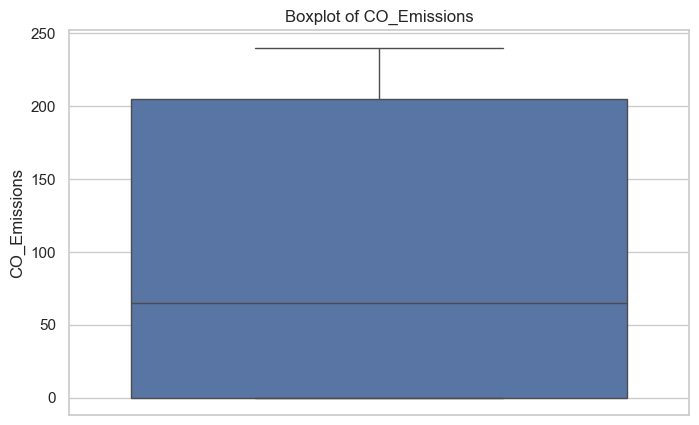

In [21]:
def detect_outliers_IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (column < lower) | (column > upper)

outliers = detect_outliers_IQR(y)
print('Number of outliers in CO_Emissions:', outliers.sum())

plt.figure(figsize=(8,5))
sns.boxplot(y)
plt.title('Boxplot of CO_Emissions')
plt.show()

## Data Distribution
We plot histograms of the target variable and examine correlations among numerical features to understand data distribution and relationships.

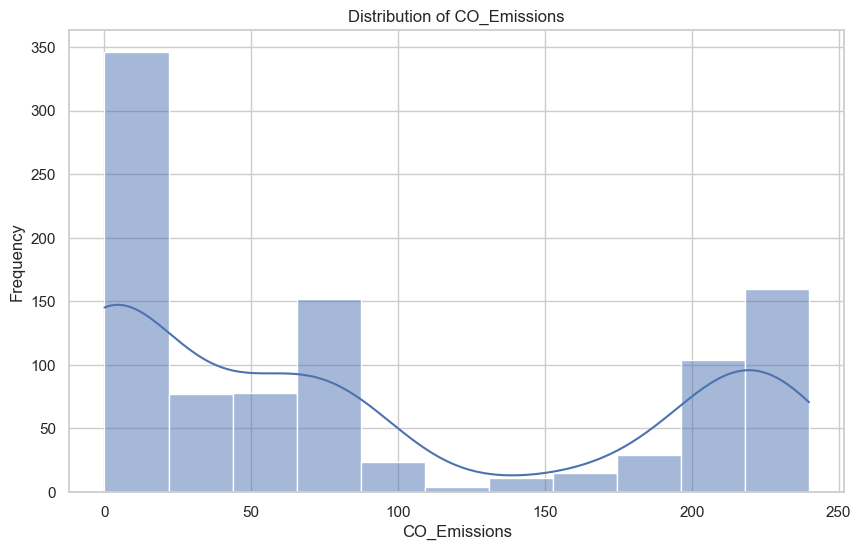

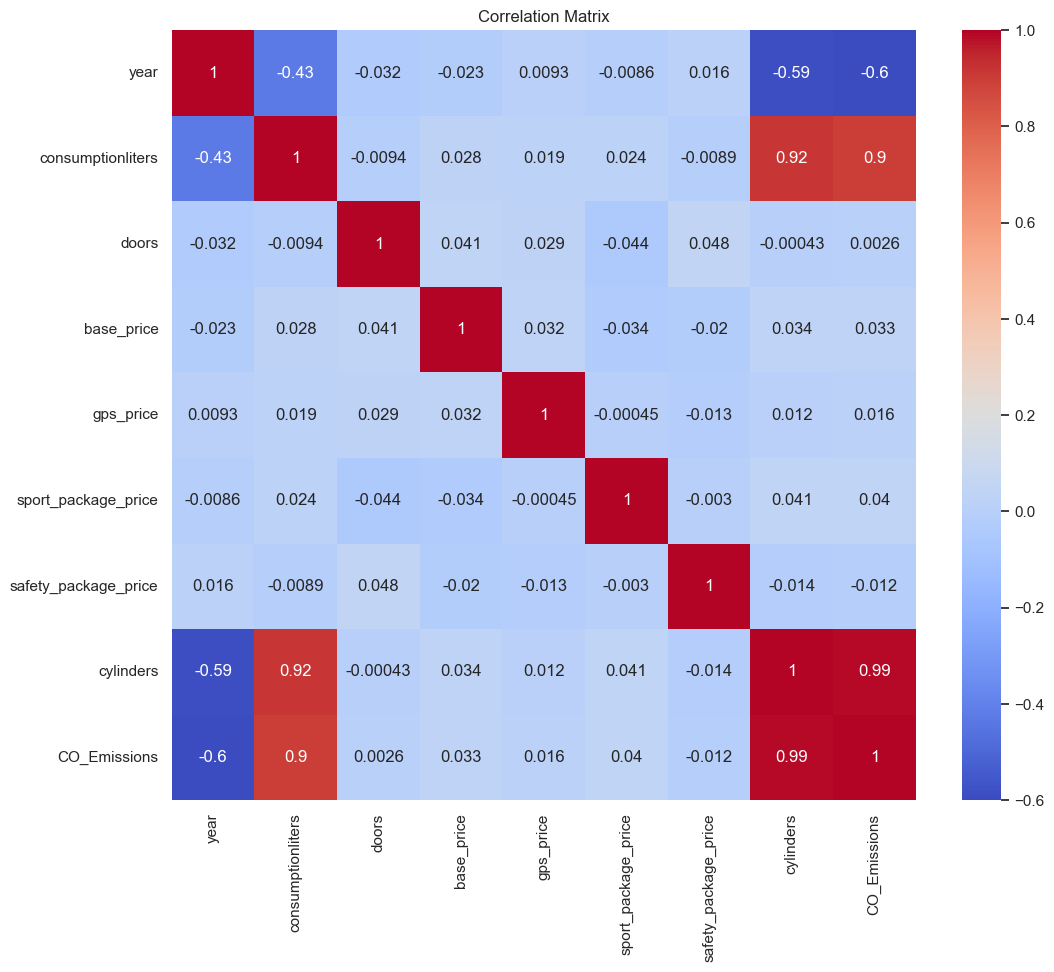

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(y, kde=True)
plt.title('Distribution of CO_Emissions')
plt.xlabel('CO_Emissions')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df[numerical_cols + ['CO_Emissions']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Preprocessing Pipeline
Numerical features: Impute missing values with mean and standardize.
Categorical features: Impute missing values with mode and apply One-Hot Encoding.
This pipeline ensures that the dataset is ready for neural network training.

In [23]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

## Train-Test Split
We split the dataset into training (80%) and test (20%) sets with shuffling. This ensures that the training data is representative and avoids bias.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)

Training set size: (800, 11)
Test set size: (200, 11)


## Apply Preprocessing
We fit the preprocessing pipeline to the training data and transform both training and test sets. This ensures that scaling and encoding are consistent.

In [25]:
X_train_pre = preprocess.fit_transform(X_train)
X_test_pre = preprocess.transform(X_test)

print('Shape after preprocessing:')
print('X_train_pre:', X_train_pre.shape)
print('X_test_pre:', X_test_pre.shape)

Shape after preprocessing:
X_train_pre: (800, 23)
X_test_pre: (200, 23)


## Save Preprocessed Data
The processed datasets are saved in `.npy` format to be used in neural network training and evaluation.

In [26]:
processed_path = base_path / 'data' / 'processed'
learn_path = base_path / 'data' / 'learn'
check_path = base_path / 'data' / 'check'

np.save(processed_path / 'X_train_preprocessed.npy', X_train_pre)
np.save(processed_path / 'X_test_preprocessed.npy', X_test_pre)
np.save(learn_path / 'y_train.npy', y_train.to_numpy())
np.save(check_path / 'y_test.npy', y_test.to_numpy())

print('Preprocessed datasets saved successfully!')

Preprocessed datasets saved successfully!
